# Module 6 Exercise 1 - Grid searching the best Artificial Neural Network classifier

## **NOTE: You need to use the Tensorflow CPU container for this exercise**

## Overview
In this module, we have been examining a data set containing around 70,000 hospital admissions, and whether any of them resulted in readmission within 30 days.  In lab 5, we created a neural network model to predict the 30-day readmission of patients based on this data.  For this exercise, you will attempt to improve that artificial neural network model by performing a grid search and tuning the hyper parameters of the model.


## Data Format
The dataset is located at `../resources/diabetes_readmission.csv` and contains the following fields:

* readmitted            
    * 1 = readmission within 30 days of discharge
    * 0 = no readmission within 30 days
* discharge             
    * 0 = discharged to home
    * 1 = discharged elsewhere
* age                   
    * 0 = 30-59
    * 1 = 0-30
    * 2 = >= 60
* race                  
    * 0 = African American
    * 1 = Caucasian
    * 2 = Unknown
    * 3 = Other
* admission_type        
    * 0 = Emergency
    * 1 = Referral
    * 2 = Other
* specialty -              specialty of admission department
     * 0 = Cardiology
     * 1 = Family/General Practice
     * 2 = Internal Medicine
     * 3 = Unknown
     * 4 = Surgery
     * 5 = Other
* time_in_hospital -       number of days in hospital
* diag_1 -                 primary diagnosis: 
    * 0 = “diabetes” for icd9: 250.xx
    * 1 = “circulatory”for icd9: 390–459, 785 
    * 2 = “digestive” for icd9: 520–579, 787
    * 3 = “genitourinary”for icd9: 580–629, 788 
    * 4 = “injury” for icd9: 800–999
    * 5 = “musculoskeletal” for icd9: 710–739 
    * 6 = “neoplasms” for icd9: 140–239
    * 7 = “respiratory” for icd9: 460–519, 786
    * 8 = “other”
* A1Cresult -              result of last HbA1C test
    * 0 = No test performed
    * 1 = Normal
    * 2 = result > 7
    * 3 = result > 8
* change -                 diabetes medication adjusted while in hospital? 0 = no, 1 = yes

## Required Output
The output from this exercise will be submitted on Canvas in the form of a written response to the assignment submission, as a PDF.  In the response, you will include the following 7 sections:

1. The hyper parameters that you grid searched, and the sets of values used for each
1. The result of your best model in terms of accuracy and AUC
1. The hyper parameters that were selected as the best
1. A description of your best neural network:
    1. How many hidden layers?
    1. How many nodes in each hidden layer?
1. A Receiver Operating Curve plot, along with the ROC's AUC as was produced in lab 5
1. A confusion matrix as was produced in lab 5
1. A classification report as was produced in lab 5


## Grading
You will be graded on the completeness of your report.  You must answer all of the above questions and include the necessary model outputs.

In addition, you will be graded on the completeness of your code. Your jupyter notebook must be able to be run from a restarted kernel and run to completion, producing the proper output, using no more than the data provided or produced from these exercises. In other words, you cannot do work outside of the jupyter notebook, save it to a file, and use that information in this project.  

You will not be graded on the selection of the hyper parameter values you chose to search; however, you **must** select one of your grid search parameters to control the number of hidden layers in your model. 

### Rubric

The report is worth 21 points, 3 points for each section.  Any missing section will result in the loss of three points.  

The jupyter notebook is worth 25 points.  Failure to submit a functioning notebook will result in a deduction of 25 points.

In [1]:
import sys
!{sys.executable} -m pip install keras==2.3.1
!{sys.executable} -m pip install --upgrade "numpy>=1.2"
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

Requirement already up-to-date: numpy>=1.2 in /opt/conda/lib/python3.7/site-packages (1.21.5)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
%matplotlib inline

## Apply transformations to our data
This code will apply the same transformations as was done in the labs.

In [3]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../resources/diabetes_readmission.csv')
display(data.head())

y = data['readmitted']
X = data[['discharge', 'age', 'race', 'admission_type', 'specialty', 'time_in_hospital', 'diag_1', 'A1Cresult', 'change']].copy()

scaler = StandardScaler()
X['time_in_hospital'] = scaler.fit_transform(X[['time_in_hospital']])

# create dummy variables
X = pd.concat([X, pd.get_dummies(X['age'], prefix = 'age', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix = 'race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['admission_type'], prefix = 'admission_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['specialty'], prefix = 'specialty', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['diag_1'], prefix = 'diag_1', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['A1Cresult'], prefix = 'A1Cresult', drop_first=True)], axis=1)

# drop originals
X = X.drop(['age', 'race', 'admission_type', 'specialty', 'diag_1', 'A1Cresult'], axis=1)

# balance the classes
display(y.value_counts())

X_oversampled, y_oversampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

X = pd.DataFrame(np.vstack((X[y == 0], X_oversampled)), columns=X.columns)
y = np.hstack((y[y == 0], y_oversampled))

display(pd.Series(y).value_counts())

,readmitted,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,1,0,0,1,1,0,8,8,0,1
1,0,0,0,1,1,4,2,8,0,0
2,0,1,2,1,1,2,4,8,2,0
3,0,0,2,1,1,2,3,8,3,1
4,0,0,0,0,1,2,5,8,0,0


0    60145
1     5813
Name: readmitted, dtype: int64

1    60145
0    60145
dtype: int64

## Create a function that will build the neural network model
Write a function to build your ANN using Keras, with the ability to specify the number of hidden layers.

In [4]:
# your code here

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn import metrics

# train/test split, specify the seed for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# create a metric function that can give us AUC at the end of each epoch
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def build_model(num_layers):
    model = Sequential()
    for l in range(num_layers, 0, -1):
        if l == num_layers:
            model.add(Dense(X_train.shape[1]*l, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
        else:
            model.add(Dense(X_train.shape[1]*l, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = keras.optimizers.Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', auc])
    
    return model

## Specify your grid search parameters

Set your grid search parameters into a python dictionary.  One of them **must** be the number of hidden layers.

In [6]:
# your code here

param_grid = {
    'num_layers': [3, 4, 5],
    'epochs': [50, 100, 150]
}


## Run the grid search
Perform the grid search using your parameters.  This step could take some time.

Use accuracy as the scoring method.

Print out the parameters of the best model and it's accuracy.

In [7]:
# your code here
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=build_model, batch_size=2048, verbose=2)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy')
grid_result = grid.fit(X, y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 1s - loss: 0.6403 - accuracy: 0.6314 - auc: 0.6046
Epoch 2/50
 - 0s - loss: 0.6327 - accuracy: 0.6379 - auc: 0.6248
Epoch 3/50
 - 0s - loss: 0.6301 - accuracy: 0.6414 - auc: 0.6309
Epoch 4/50
 - 0s - loss: 0.6280 - accuracy: 0.6417 - auc: 0.6347
Epoch 5/50
 - 0s - loss: 0.6259 - accuracy: 0.6444 - auc: 0.6375
Epoch 6/50
 - 0s - loss: 0.6247 - accuracy: 0.6448 - auc: 0.6401
Epoch 7/50
 - 0s - loss: 0.6219 - accuracy: 0.6498 - auc: 0.6420
Epoch 8/50
 - 0s - loss: 0.6201 - accuracy: 0.6503 - auc: 0.6441
Epoch 9/50
 - 0s - loss: 0.6173 - accuracy: 0.6541 - auc: 0.6461
Epoch 10/50
 - 0s - loss: 0.6156 - accuracy: 0.6553 - auc: 0.6481
Epoch 11/50
 - 0s - loss: 0.6139 - accuracy: 0.6573 - auc: 0.6498
Epoch 12/50
 - 0s - loss: 0.6121 - ac

 - 0s - loss: 0.6506 - accuracy: 0.6103 - auc: 0.6317
Epoch 10/50
 - 0s - loss: 0.6481 - accuracy: 0.6105 - auc: 0.6343
Epoch 11/50
 - 0s - loss: 0.6457 - accuracy: 0.6136 - auc: 0.6367
Epoch 12/50
 - 0s - loss: 0.6431 - accuracy: 0.6161 - auc: 0.6389
Epoch 13/50
 - 0s - loss: 0.6423 - accuracy: 0.6166 - auc: 0.6411
Epoch 14/50
 - 0s - loss: 0.6388 - accuracy: 0.6195 - auc: 0.6432
Epoch 15/50
 - 0s - loss: 0.6367 - accuracy: 0.6226 - auc: 0.6451
Epoch 16/50
 - 0s - loss: 0.6352 - accuracy: 0.6232 - auc: 0.6472
Epoch 17/50
 - 0s - loss: 0.6322 - accuracy: 0.6248 - auc: 0.6489
Epoch 18/50
 - 0s - loss: 0.6322 - accuracy: 0.6248 - auc: 0.6508
Epoch 19/50
 - 0s - loss: 0.6308 - accuracy: 0.6257 - auc: 0.6522
Epoch 20/50
 - 0s - loss: 0.6293 - accuracy: 0.6267 - auc: 0.6537
Epoch 21/50
 - 0s - loss: 0.6283 - accuracy: 0.6274 - auc: 0.6552
Epoch 22/50
 - 0s - loss: 0.6251 - accuracy: 0.6306 - auc: 0.6567
Epoch 23/50
 - 0s - loss: 0.6240 - accuracy: 0.6311 - auc: 0.6581
Epoch 24/50
 - 0s - lo

Epoch 34/50
 - 0s - loss: 0.5874 - accuracy: 0.6687 - auc: 0.6744
Epoch 35/50
 - 0s - loss: 0.5864 - accuracy: 0.6701 - auc: 0.6754
Epoch 36/50
 - 0s - loss: 0.5881 - accuracy: 0.6695 - auc: 0.6762
Epoch 37/50
 - 0s - loss: 0.5864 - accuracy: 0.6693 - auc: 0.6771
Epoch 38/50
 - 0s - loss: 0.5849 - accuracy: 0.6705 - auc: 0.6779
Epoch 39/50
 - 0s - loss: 0.5844 - accuracy: 0.6709 - auc: 0.6787
Epoch 40/50
 - 0s - loss: 0.5850 - accuracy: 0.6703 - auc: 0.6794
Epoch 41/50
 - 0s - loss: 0.5839 - accuracy: 0.6705 - auc: 0.6801
Epoch 42/50
 - 0s - loss: 0.5829 - accuracy: 0.6706 - auc: 0.6809
Epoch 43/50
 - 0s - loss: 0.5826 - accuracy: 0.6725 - auc: 0.6816
Epoch 44/50
 - 0s - loss: 0.5823 - accuracy: 0.6713 - auc: 0.6823
Epoch 45/50
 - 0s - loss: 0.5816 - accuracy: 0.6730 - auc: 0.6830
Epoch 46/50
 - 0s - loss: 0.5815 - accuracy: 0.6717 - auc: 0.6836
Epoch 47/50
 - 0s - loss: 0.5794 - accuracy: 0.6733 - auc: 0.6843
Epoch 48/50
 - 0s - loss: 0.5791 - accuracy: 0.6746 - auc: 0.6849
Epoch 49/5

Epoch 9/50
 - 0s - loss: 0.6426 - accuracy: 0.6163 - auc: 0.6386
Epoch 10/50
 - 0s - loss: 0.6397 - accuracy: 0.6187 - auc: 0.6418
Epoch 11/50
 - 0s - loss: 0.6353 - accuracy: 0.6228 - auc: 0.6448
Epoch 12/50
 - 0s - loss: 0.6320 - accuracy: 0.6247 - auc: 0.6476
Epoch 13/50
 - 0s - loss: 0.6310 - accuracy: 0.6243 - auc: 0.6502
Epoch 14/50
 - 0s - loss: 0.6262 - accuracy: 0.6276 - auc: 0.6526
Epoch 15/50
 - 0s - loss: 0.6243 - accuracy: 0.6297 - auc: 0.6550
Epoch 16/50
 - 0s - loss: 0.6220 - accuracy: 0.6316 - auc: 0.6573
Epoch 17/50
 - 0s - loss: 0.6185 - accuracy: 0.6350 - auc: 0.6594
Epoch 18/50
 - 0s - loss: 0.6174 - accuracy: 0.6367 - auc: 0.6615
Epoch 19/50
 - 0s - loss: 0.6180 - accuracy: 0.6339 - auc: 0.6635
Epoch 20/50
 - 0s - loss: 0.6127 - accuracy: 0.6393 - auc: 0.6653
Epoch 21/50
 - 0s - loss: 0.6097 - accuracy: 0.6416 - auc: 0.6672
Epoch 22/50
 - 0s - loss: 0.6090 - accuracy: 0.6409 - auc: 0.6690
Epoch 23/50
 - 0s - loss: 0.6065 - accuracy: 0.6440 - auc: 0.6708
Epoch 24/50

Epoch 34/50
 - 0s - loss: 0.5814 - accuracy: 0.6678 - auc: 0.6730
Epoch 35/50
 - 0s - loss: 0.5803 - accuracy: 0.6679 - auc: 0.6741
Epoch 36/50
 - 0s - loss: 0.5811 - accuracy: 0.6673 - auc: 0.6750
Epoch 37/50
 - 0s - loss: 0.5806 - accuracy: 0.6678 - auc: 0.6760
Epoch 38/50
 - 0s - loss: 0.5791 - accuracy: 0.6684 - auc: 0.6769
Epoch 39/50
 - 0s - loss: 0.5781 - accuracy: 0.6685 - auc: 0.6778
Epoch 40/50
 - 0s - loss: 0.5797 - accuracy: 0.6678 - auc: 0.6786
Epoch 41/50
 - 0s - loss: 0.5770 - accuracy: 0.6702 - auc: 0.6794
Epoch 42/50
 - 0s - loss: 0.5760 - accuracy: 0.6703 - auc: 0.6803
Epoch 43/50
 - 0s - loss: 0.5758 - accuracy: 0.6714 - auc: 0.6810
Epoch 44/50
 - 0s - loss: 0.5761 - accuracy: 0.6714 - auc: 0.6818
Epoch 45/50
 - 0s - loss: 0.5761 - accuracy: 0.6698 - auc: 0.6825
Epoch 46/50
 - 0s - loss: 0.5737 - accuracy: 0.6715 - auc: 0.6833
Epoch 47/50
 - 0s - loss: 0.5738 - accuracy: 0.6704 - auc: 0.6840
Epoch 48/50
 - 0s - loss: 0.5731 - accuracy: 0.6718 - auc: 0.6847
Epoch 49/5

Epoch 9/50
 - 0s - loss: 0.6375 - accuracy: 0.6184 - auc: 0.6400
Epoch 10/50
 - 0s - loss: 0.6327 - accuracy: 0.6223 - auc: 0.6433
Epoch 11/50
 - 0s - loss: 0.6316 - accuracy: 0.6227 - auc: 0.6465
Epoch 12/50
 - 0s - loss: 0.6271 - accuracy: 0.6278 - auc: 0.6494
Epoch 13/50
 - 0s - loss: 0.6225 - accuracy: 0.6308 - auc: 0.6524
Epoch 14/50
 - 0s - loss: 0.6213 - accuracy: 0.6323 - auc: 0.6553
Epoch 15/50
 - 0s - loss: 0.6211 - accuracy: 0.6324 - auc: 0.6577
Epoch 16/50
 - 0s - loss: 0.6161 - accuracy: 0.6362 - auc: 0.6601
Epoch 17/50
 - 0s - loss: 0.6133 - accuracy: 0.6384 - auc: 0.6623
Epoch 18/50
 - 0s - loss: 0.6126 - accuracy: 0.6383 - auc: 0.6645
Epoch 19/50
 - 0s - loss: 0.6134 - accuracy: 0.6388 - auc: 0.6666
Epoch 20/50
 - 0s - loss: 0.6113 - accuracy: 0.6394 - auc: 0.6683
Epoch 21/50
 - 0s - loss: 0.6062 - accuracy: 0.6437 - auc: 0.6702
Epoch 22/50
 - 0s - loss: 0.6070 - accuracy: 0.6424 - auc: 0.6719
Epoch 23/50
 - 0s - loss: 0.6039 - accuracy: 0.6439 - auc: 0.6735
Epoch 24/50

Epoch 34/50
 - 0s - loss: 0.5725 - accuracy: 0.6766 - auc: 0.6838
Epoch 35/50
 - 0s - loss: 0.5714 - accuracy: 0.6783 - auc: 0.6849
Epoch 36/50
 - 0s - loss: 0.5714 - accuracy: 0.6774 - auc: 0.6859
Epoch 37/50
 - 0s - loss: 0.5687 - accuracy: 0.6776 - auc: 0.6870
Epoch 38/50
 - 0s - loss: 0.5698 - accuracy: 0.6790 - auc: 0.6880
Epoch 39/50
 - 0s - loss: 0.5679 - accuracy: 0.6807 - auc: 0.6890
Epoch 40/50
 - 0s - loss: 0.5681 - accuracy: 0.6805 - auc: 0.6899
Epoch 41/50
 - 0s - loss: 0.5673 - accuracy: 0.6801 - auc: 0.6908
Epoch 42/50
 - 0s - loss: 0.5656 - accuracy: 0.6805 - auc: 0.6917
Epoch 43/50
 - 0s - loss: 0.5655 - accuracy: 0.6807 - auc: 0.6926
Epoch 44/50
 - 0s - loss: 0.5645 - accuracy: 0.6804 - auc: 0.6934
Epoch 45/50
 - 0s - loss: 0.5649 - accuracy: 0.6818 - auc: 0.6942
Epoch 46/50
 - 0s - loss: 0.5644 - accuracy: 0.6812 - auc: 0.6950
Epoch 47/50
 - 0s - loss: 0.5638 - accuracy: 0.6812 - auc: 0.6958
Epoch 48/50
 - 0s - loss: 0.5647 - accuracy: 0.6809 - auc: 0.6965
Epoch 49/5

Epoch 7/100
 - 0s - loss: 0.6108 - accuracy: 0.6722 - auc: 0.6476
Epoch 8/100
 - 0s - loss: 0.6081 - accuracy: 0.6745 - auc: 0.6505
Epoch 9/100
 - 0s - loss: 0.6046 - accuracy: 0.6773 - auc: 0.6533
Epoch 10/100
 - 0s - loss: 0.6012 - accuracy: 0.6797 - auc: 0.6561
Epoch 11/100
 - 0s - loss: 0.5997 - accuracy: 0.6801 - auc: 0.6586
Epoch 12/100
 - 0s - loss: 0.5960 - accuracy: 0.6844 - auc: 0.6609
Epoch 13/100
 - 0s - loss: 0.5929 - accuracy: 0.6862 - auc: 0.6633
Epoch 14/100
 - 0s - loss: 0.5914 - accuracy: 0.6874 - auc: 0.6655
Epoch 15/100
 - 0s - loss: 0.5901 - accuracy: 0.6871 - auc: 0.6675
Epoch 16/100
 - 0s - loss: 0.5869 - accuracy: 0.6896 - auc: 0.6695
Epoch 17/100
 - 0s - loss: 0.5844 - accuracy: 0.6915 - auc: 0.6713
Epoch 18/100
 - 0s - loss: 0.5834 - accuracy: 0.6925 - auc: 0.6730
Epoch 19/100
 - 0s - loss: 0.5807 - accuracy: 0.6955 - auc: 0.6748
Epoch 20/100
 - 0s - loss: 0.5801 - accuracy: 0.6955 - auc: 0.6764
Epoch 21/100
 - 0s - loss: 0.5799 - accuracy: 0.6959 - auc: 0.677

Epoch 30/100
 - 0s - loss: 0.6148 - accuracy: 0.6385 - auc: 0.6726
Epoch 31/100
 - 0s - loss: 0.6124 - accuracy: 0.6417 - auc: 0.6736
Epoch 32/100
 - 0s - loss: 0.6118 - accuracy: 0.6404 - auc: 0.6745
Epoch 33/100
 - 0s - loss: 0.6103 - accuracy: 0.6422 - auc: 0.6755
Epoch 34/100
 - 0s - loss: 0.6109 - accuracy: 0.6411 - auc: 0.6764
Epoch 35/100
 - 0s - loss: 0.6086 - accuracy: 0.6424 - auc: 0.6773
Epoch 36/100
 - 0s - loss: 0.6086 - accuracy: 0.6441 - auc: 0.6782
Epoch 37/100
 - 0s - loss: 0.6064 - accuracy: 0.6459 - auc: 0.6790
Epoch 38/100
 - 0s - loss: 0.6065 - accuracy: 0.6455 - auc: 0.6799
Epoch 39/100
 - 0s - loss: 0.6069 - accuracy: 0.6453 - auc: 0.6807
Epoch 40/100
 - 0s - loss: 0.6069 - accuracy: 0.6452 - auc: 0.6814
Epoch 41/100
 - 0s - loss: 0.6058 - accuracy: 0.6466 - auc: 0.6822
Epoch 42/100
 - 0s - loss: 0.6056 - accuracy: 0.6468 - auc: 0.6829
Epoch 43/100
 - 0s - loss: 0.6051 - accuracy: 0.6471 - auc: 0.6836
Epoch 44/100
 - 0s - loss: 0.6055 - accuracy: 0.6465 - auc: 0.

Epoch 53/100
 - 0s - loss: 0.5808 - accuracy: 0.6692 - auc: 0.6846
Epoch 54/100
 - 0s - loss: 0.5785 - accuracy: 0.6731 - auc: 0.6851
Epoch 55/100
 - 0s - loss: 0.5789 - accuracy: 0.6717 - auc: 0.6857
Epoch 56/100
 - 0s - loss: 0.5780 - accuracy: 0.6730 - auc: 0.6862
Epoch 57/100
 - 0s - loss: 0.5784 - accuracy: 0.6732 - auc: 0.6868
Epoch 58/100
 - 0s - loss: 0.5768 - accuracy: 0.6719 - auc: 0.6873
Epoch 59/100
 - 0s - loss: 0.5765 - accuracy: 0.6744 - auc: 0.6878
Epoch 60/100
 - 0s - loss: 0.5769 - accuracy: 0.6730 - auc: 0.6883
Epoch 61/100
 - 0s - loss: 0.5771 - accuracy: 0.6741 - auc: 0.6888
Epoch 62/100
 - 0s - loss: 0.5775 - accuracy: 0.6740 - auc: 0.6893
Epoch 63/100
 - 0s - loss: 0.5753 - accuracy: 0.6744 - auc: 0.6897
Epoch 64/100
 - 0s - loss: 0.5753 - accuracy: 0.6754 - auc: 0.6902
Epoch 65/100
 - 0s - loss: 0.5751 - accuracy: 0.6752 - auc: 0.6907
Epoch 66/100
 - 0s - loss: 0.5744 - accuracy: 0.6743 - auc: 0.6911
Epoch 67/100
 - 0s - loss: 0.5753 - accuracy: 0.6740 - auc: 0.

Epoch 76/100
 - 0s - loss: 0.5844 - accuracy: 0.6674 - auc: 0.6728
Epoch 77/100
 - 0s - loss: 0.5849 - accuracy: 0.6671 - auc: 0.6732
Epoch 78/100
 - 0s - loss: 0.5842 - accuracy: 0.6684 - auc: 0.6737
Epoch 79/100
 - 0s - loss: 0.5837 - accuracy: 0.6678 - auc: 0.6741
Epoch 80/100
 - 0s - loss: 0.5833 - accuracy: 0.6681 - auc: 0.6746
Epoch 81/100
 - 0s - loss: 0.5831 - accuracy: 0.6676 - auc: 0.6750
Epoch 82/100
 - 0s - loss: 0.5828 - accuracy: 0.6691 - auc: 0.6754
Epoch 83/100
 - 0s - loss: 0.5825 - accuracy: 0.6690 - auc: 0.6759
Epoch 84/100
 - 0s - loss: 0.5832 - accuracy: 0.6681 - auc: 0.6763
Epoch 85/100
 - 0s - loss: 0.5824 - accuracy: 0.6683 - auc: 0.6767
Epoch 86/100
 - 0s - loss: 0.5822 - accuracy: 0.6681 - auc: 0.6771
Epoch 87/100
 - 0s - loss: 0.5817 - accuracy: 0.6684 - auc: 0.6775
Epoch 88/100
 - 0s - loss: 0.5811 - accuracy: 0.6689 - auc: 0.6778
Epoch 89/100
 - 0s - loss: 0.5802 - accuracy: 0.6707 - auc: 0.6782
Epoch 90/100
 - 0s - loss: 0.5805 - accuracy: 0.6701 - auc: 0.

Epoch 99/100
 - 0s - loss: 0.5507 - accuracy: 0.7003 - auc: 0.7126
Epoch 100/100
 - 0s - loss: 0.5504 - accuracy: 0.7001 - auc: 0.7129
Epoch 1/100
 - 1s - loss: 0.6395 - accuracy: 0.6399 - auc: 0.6054
Epoch 2/100
 - 0s - loss: 0.6297 - accuracy: 0.6535 - auc: 0.6280
Epoch 3/100
 - 0s - loss: 0.6258 - accuracy: 0.6580 - auc: 0.6352
Epoch 4/100
 - 0s - loss: 0.6219 - accuracy: 0.6612 - auc: 0.6397
Epoch 5/100
 - 0s - loss: 0.6176 - accuracy: 0.6658 - auc: 0.6434
Epoch 6/100
 - 0s - loss: 0.6125 - accuracy: 0.6698 - auc: 0.6467
Epoch 7/100
 - 0s - loss: 0.6093 - accuracy: 0.6733 - auc: 0.6498
Epoch 8/100
 - 0s - loss: 0.6048 - accuracy: 0.6777 - auc: 0.6530
Epoch 9/100
 - 0s - loss: 0.6010 - accuracy: 0.6792 - auc: 0.6558
Epoch 10/100
 - 0s - loss: 0.5971 - accuracy: 0.6836 - auc: 0.6588
Epoch 11/100
 - 0s - loss: 0.5943 - accuracy: 0.6839 - auc: 0.6613
Epoch 12/100
 - 0s - loss: 0.5904 - accuracy: 0.6880 - auc: 0.6638
Epoch 13/100
 - 0s - loss: 0.5885 - accuracy: 0.6889 - auc: 0.6662
Epo

Epoch 22/100
 - 0s - loss: 0.6069 - accuracy: 0.6427 - auc: 0.6730
Epoch 23/100
 - 0s - loss: 0.6044 - accuracy: 0.6454 - auc: 0.6746
Epoch 24/100
 - 0s - loss: 0.6058 - accuracy: 0.6442 - auc: 0.6761
Epoch 25/100
 - 0s - loss: 0.6037 - accuracy: 0.6447 - auc: 0.6775
Epoch 26/100
 - 0s - loss: 0.6013 - accuracy: 0.6460 - auc: 0.6789
Epoch 27/100
 - 0s - loss: 0.5992 - accuracy: 0.6481 - auc: 0.6802
Epoch 28/100
 - 0s - loss: 0.5973 - accuracy: 0.6505 - auc: 0.6816
Epoch 29/100
 - 0s - loss: 0.5978 - accuracy: 0.6497 - auc: 0.6829
Epoch 30/100
 - 0s - loss: 0.5994 - accuracy: 0.6484 - auc: 0.6841
Epoch 31/100
 - 0s - loss: 0.5956 - accuracy: 0.6509 - auc: 0.6853
Epoch 32/100
 - 0s - loss: 0.5961 - accuracy: 0.6510 - auc: 0.6864
Epoch 33/100
 - 0s - loss: 0.5938 - accuracy: 0.6520 - auc: 0.6875
Epoch 34/100
 - 0s - loss: 0.5933 - accuracy: 0.6543 - auc: 0.6886
Epoch 35/100
 - 0s - loss: 0.5941 - accuracy: 0.6519 - auc: 0.6896
Epoch 36/100
 - 0s - loss: 0.5920 - accuracy: 0.6542 - auc: 0.

Epoch 45/100
 - 0s - loss: 0.5693 - accuracy: 0.6801 - auc: 0.6897
Epoch 46/100
 - 0s - loss: 0.5679 - accuracy: 0.6801 - auc: 0.6905
Epoch 47/100
 - 0s - loss: 0.5673 - accuracy: 0.6800 - auc: 0.6913
Epoch 48/100
 - 0s - loss: 0.5684 - accuracy: 0.6800 - auc: 0.6920
Epoch 49/100
 - 0s - loss: 0.5668 - accuracy: 0.6814 - auc: 0.6927
Epoch 50/100
 - 0s - loss: 0.5670 - accuracy: 0.6812 - auc: 0.6935
Epoch 51/100
 - 0s - loss: 0.5663 - accuracy: 0.6821 - auc: 0.6941
Epoch 52/100
 - 0s - loss: 0.5636 - accuracy: 0.6829 - auc: 0.6949
Epoch 53/100
 - 0s - loss: 0.5640 - accuracy: 0.6840 - auc: 0.6956
Epoch 54/100
 - 0s - loss: 0.5653 - accuracy: 0.6818 - auc: 0.6962
Epoch 55/100
 - 0s - loss: 0.5666 - accuracy: 0.6804 - auc: 0.6968
Epoch 56/100
 - 0s - loss: 0.5660 - accuracy: 0.6813 - auc: 0.6974
Epoch 57/100
 - 0s - loss: 0.5640 - accuracy: 0.6828 - auc: 0.6980
Epoch 58/100
 - 0s - loss: 0.5625 - accuracy: 0.6836 - auc: 0.6986
Epoch 59/100
 - 0s - loss: 0.5626 - accuracy: 0.6830 - auc: 0.

Epoch 68/100
 - 0s - loss: 0.5612 - accuracy: 0.6822 - auc: 0.7008
Epoch 69/100
 - 0s - loss: 0.5604 - accuracy: 0.6835 - auc: 0.7013
Epoch 70/100
 - 0s - loss: 0.5611 - accuracy: 0.6828 - auc: 0.7018
Epoch 71/100
 - 0s - loss: 0.5615 - accuracy: 0.6817 - auc: 0.7022
Epoch 72/100
 - 0s - loss: 0.5605 - accuracy: 0.6826 - auc: 0.7027
Epoch 73/100
 - 0s - loss: 0.5601 - accuracy: 0.6826 - auc: 0.7031
Epoch 74/100
 - 0s - loss: 0.5607 - accuracy: 0.6835 - auc: 0.7035
Epoch 75/100
 - 0s - loss: 0.5587 - accuracy: 0.6838 - auc: 0.7039
Epoch 76/100
 - 0s - loss: 0.5590 - accuracy: 0.6835 - auc: 0.7044
Epoch 77/100
 - 0s - loss: 0.5584 - accuracy: 0.6846 - auc: 0.7048
Epoch 78/100
 - 0s - loss: 0.5595 - accuracy: 0.6852 - auc: 0.7052
Epoch 79/100
 - 0s - loss: 0.5592 - accuracy: 0.6838 - auc: 0.7055
Epoch 80/100
 - 0s - loss: 0.5589 - accuracy: 0.6843 - auc: 0.7059
Epoch 81/100
 - 0s - loss: 0.5590 - accuracy: 0.6842 - auc: 0.7063
Epoch 82/100
 - 0s - loss: 0.5594 - accuracy: 0.6845 - auc: 0.

Epoch 91/100
 - 0s - loss: 0.5497 - accuracy: 0.6998 - auc: 0.7129
Epoch 92/100
 - 0s - loss: 0.5496 - accuracy: 0.6995 - auc: 0.7132
Epoch 93/100
 - 0s - loss: 0.5513 - accuracy: 0.6992 - auc: 0.7135
Epoch 94/100
 - 0s - loss: 0.5504 - accuracy: 0.6996 - auc: 0.7138
Epoch 95/100
 - 0s - loss: 0.5533 - accuracy: 0.6993 - auc: 0.7141
Epoch 96/100
 - 0s - loss: 0.5494 - accuracy: 0.7005 - auc: 0.7143
Epoch 97/100
 - 0s - loss: 0.5492 - accuracy: 0.7013 - auc: 0.7146
Epoch 98/100
 - 0s - loss: 0.5484 - accuracy: 0.7015 - auc: 0.7149
Epoch 99/100
 - 0s - loss: 0.5477 - accuracy: 0.7007 - auc: 0.7152
Epoch 100/100
 - 0s - loss: 0.5493 - accuracy: 0.7003 - auc: 0.7155
Epoch 1/100
 - 1s - loss: 0.6415 - accuracy: 0.6401 - auc: 0.5936
Epoch 2/100
 - 0s - loss: 0.6314 - accuracy: 0.6518 - auc: 0.6230
Epoch 3/100
 - 0s - loss: 0.6266 - accuracy: 0.6583 - auc: 0.6313
Epoch 4/100
 - 0s - loss: 0.6217 - accuracy: 0.6607 - auc: 0.6368
Epoch 5/100
 - 0s - loss: 0.6180 - accuracy: 0.6636 - auc: 0.6412

Epoch 14/100
 - 0s - loss: 0.6232 - accuracy: 0.6299 - auc: 0.6533
Epoch 15/100
 - 0s - loss: 0.6210 - accuracy: 0.6314 - auc: 0.6558
Epoch 16/100
 - 0s - loss: 0.6194 - accuracy: 0.6335 - auc: 0.6581
Epoch 17/100
 - 0s - loss: 0.6174 - accuracy: 0.6348 - auc: 0.6603
Epoch 18/100
 - 0s - loss: 0.6143 - accuracy: 0.6368 - auc: 0.6623
Epoch 19/100
 - 0s - loss: 0.6132 - accuracy: 0.6374 - auc: 0.6643
Epoch 20/100
 - 0s - loss: 0.6121 - accuracy: 0.6377 - auc: 0.6661
Epoch 21/100
 - 0s - loss: 0.6100 - accuracy: 0.6398 - auc: 0.6679
Epoch 22/100
 - 0s - loss: 0.6076 - accuracy: 0.6423 - auc: 0.6697
Epoch 23/100
 - 0s - loss: 0.6053 - accuracy: 0.6447 - auc: 0.6713
Epoch 24/100
 - 0s - loss: 0.6041 - accuracy: 0.6438 - auc: 0.6730
Epoch 25/100
 - 0s - loss: 0.6037 - accuracy: 0.6441 - auc: 0.6746
Epoch 26/100
 - 0s - loss: 0.6041 - accuracy: 0.6435 - auc: 0.6760
Epoch 27/100
 - 0s - loss: 0.5986 - accuracy: 0.6464 - auc: 0.6774
Epoch 28/100
 - 0s - loss: 0.5974 - accuracy: 0.6475 - auc: 0.

Epoch 37/100
 - 0s - loss: 0.5691 - accuracy: 0.6782 - auc: 0.6859
Epoch 38/100
 - 0s - loss: 0.5698 - accuracy: 0.6790 - auc: 0.6869
Epoch 39/100
 - 0s - loss: 0.5680 - accuracy: 0.6799 - auc: 0.6880
Epoch 40/100
 - 0s - loss: 0.5664 - accuracy: 0.6797 - auc: 0.6890
Epoch 41/100
 - 0s - loss: 0.5642 - accuracy: 0.6809 - auc: 0.6899
Epoch 42/100
 - 0s - loss: 0.5632 - accuracy: 0.6819 - auc: 0.6909
Epoch 43/100
 - 0s - loss: 0.5647 - accuracy: 0.6813 - auc: 0.6919
Epoch 44/100
 - 0s - loss: 0.5646 - accuracy: 0.6802 - auc: 0.6928
Epoch 45/100
 - 0s - loss: 0.5658 - accuracy: 0.6806 - auc: 0.6936
Epoch 46/100
 - 0s - loss: 0.5632 - accuracy: 0.6814 - auc: 0.6944
Epoch 47/100
 - 0s - loss: 0.5624 - accuracy: 0.6832 - auc: 0.6952
Epoch 48/100
 - 0s - loss: 0.5636 - accuracy: 0.6812 - auc: 0.6960
Epoch 49/100
 - 0s - loss: 0.5618 - accuracy: 0.6831 - auc: 0.6967
Epoch 50/100
 - 0s - loss: 0.5634 - accuracy: 0.6820 - auc: 0.6974
Epoch 51/100
 - 0s - loss: 0.5617 - accuracy: 0.6833 - auc: 0.

Epoch 60/100
 - 0s - loss: 0.5603 - accuracy: 0.6843 - auc: 0.7003
Epoch 61/100
 - 0s - loss: 0.5599 - accuracy: 0.6839 - auc: 0.7008
Epoch 62/100
 - 0s - loss: 0.5612 - accuracy: 0.6838 - auc: 0.7013
Epoch 63/100
 - 0s - loss: 0.5584 - accuracy: 0.6865 - auc: 0.7019
Epoch 64/100
 - 0s - loss: 0.5594 - accuracy: 0.6863 - auc: 0.7024
Epoch 65/100
 - 0s - loss: 0.5589 - accuracy: 0.6857 - auc: 0.7029
Epoch 66/100
 - 0s - loss: 0.5590 - accuracy: 0.6858 - auc: 0.7034
Epoch 67/100
 - 1s - loss: 0.5587 - accuracy: 0.6855 - auc: 0.7039
Epoch 68/100
 - 0s - loss: 0.5583 - accuracy: 0.6863 - auc: 0.7044
Epoch 69/100
 - 0s - loss: 0.5585 - accuracy: 0.6856 - auc: 0.7048
Epoch 70/100
 - 0s - loss: 0.5580 - accuracy: 0.6874 - auc: 0.7053
Epoch 71/100
 - 0s - loss: 0.5560 - accuracy: 0.6866 - auc: 0.7057
Epoch 72/100
 - 0s - loss: 0.5567 - accuracy: 0.6871 - auc: 0.7062
Epoch 73/100
 - 0s - loss: 0.5549 - accuracy: 0.6874 - auc: 0.7066
Epoch 74/100
 - 0s - loss: 0.5567 - accuracy: 0.6864 - auc: 0.

Epoch 83/150
 - 0s - loss: 0.5668 - accuracy: 0.6904 - auc: 0.7024
Epoch 84/150
 - 0s - loss: 0.5654 - accuracy: 0.6919 - auc: 0.7026
Epoch 85/150
 - 0s - loss: 0.5665 - accuracy: 0.6906 - auc: 0.7029
Epoch 86/150
 - 0s - loss: 0.5658 - accuracy: 0.6908 - auc: 0.7032
Epoch 87/150
 - 0s - loss: 0.5648 - accuracy: 0.6908 - auc: 0.7035
Epoch 88/150
 - 0s - loss: 0.5642 - accuracy: 0.6914 - auc: 0.7038
Epoch 89/150
 - 0s - loss: 0.5648 - accuracy: 0.6911 - auc: 0.7040
Epoch 90/150
 - 0s - loss: 0.5653 - accuracy: 0.6915 - auc: 0.7043
Epoch 91/150
 - 0s - loss: 0.5653 - accuracy: 0.6906 - auc: 0.7046
Epoch 92/150
 - 0s - loss: 0.5657 - accuracy: 0.6926 - auc: 0.7048
Epoch 93/150
 - 0s - loss: 0.5650 - accuracy: 0.6912 - auc: 0.7050
Epoch 94/150
 - 0s - loss: 0.5647 - accuracy: 0.6912 - auc: 0.7053
Epoch 95/150
 - 0s - loss: 0.5638 - accuracy: 0.6919 - auc: 0.7055
Epoch 96/150
 - 0s - loss: 0.5641 - accuracy: 0.6930 - auc: 0.7058
Epoch 97/150
 - 0s - loss: 0.5628 - accuracy: 0.6936 - auc: 0.

Epoch 55/150
 - 0s - loss: 0.5578 - accuracy: 0.7100 - auc: 0.7041
Epoch 56/150
 - 0s - loss: 0.5584 - accuracy: 0.7101 - auc: 0.7046
Epoch 57/150
 - 0s - loss: 0.5566 - accuracy: 0.7111 - auc: 0.7051
Epoch 58/150
 - 0s - loss: 0.5573 - accuracy: 0.7109 - auc: 0.7055
Epoch 59/150
 - 0s - loss: 0.5569 - accuracy: 0.7096 - auc: 0.7060
Epoch 60/150
 - 0s - loss: 0.5562 - accuracy: 0.7095 - auc: 0.7064
Epoch 61/150
 - 0s - loss: 0.5552 - accuracy: 0.7114 - auc: 0.7068
Epoch 62/150
 - 0s - loss: 0.5554 - accuracy: 0.7116 - auc: 0.7073
Epoch 63/150
 - 0s - loss: 0.5536 - accuracy: 0.7121 - auc: 0.7077
Epoch 64/150
 - 0s - loss: 0.5556 - accuracy: 0.7103 - auc: 0.7081
Epoch 65/150
 - 0s - loss: 0.5561 - accuracy: 0.7105 - auc: 0.7085
Epoch 66/150
 - 0s - loss: 0.5531 - accuracy: 0.7125 - auc: 0.7089
Epoch 67/150
 - 0s - loss: 0.5544 - accuracy: 0.7120 - auc: 0.7093
Epoch 68/150
 - 0s - loss: 0.5541 - accuracy: 0.7118 - auc: 0.7096
Epoch 69/150
 - 0s - loss: 0.5534 - accuracy: 0.7119 - auc: 0.

Epoch 27/150
 - 0s - loss: 0.6164 - accuracy: 0.6379 - auc: 0.6673
Epoch 28/150
 - 0s - loss: 0.6147 - accuracy: 0.6385 - auc: 0.6684
Epoch 29/150
 - 0s - loss: 0.6149 - accuracy: 0.6371 - auc: 0.6695
Epoch 30/150
 - 0s - loss: 0.6144 - accuracy: 0.6384 - auc: 0.6706
Epoch 31/150
 - 0s - loss: 0.6126 - accuracy: 0.6404 - auc: 0.6716
Epoch 32/150
 - 0s - loss: 0.6132 - accuracy: 0.6392 - auc: 0.6726
Epoch 33/150
 - 0s - loss: 0.6117 - accuracy: 0.6397 - auc: 0.6735
Epoch 34/150
 - 0s - loss: 0.6119 - accuracy: 0.6407 - auc: 0.6744
Epoch 35/150
 - 0s - loss: 0.6094 - accuracy: 0.6421 - auc: 0.6753
Epoch 36/150
 - 0s - loss: 0.6095 - accuracy: 0.6416 - auc: 0.6762
Epoch 37/150
 - 0s - loss: 0.6075 - accuracy: 0.6434 - auc: 0.6771
Epoch 38/150
 - 0s - loss: 0.6082 - accuracy: 0.6419 - auc: 0.6779
Epoch 39/150
 - 0s - loss: 0.6086 - accuracy: 0.6435 - auc: 0.6787
Epoch 40/150
 - 0s - loss: 0.6063 - accuracy: 0.6444 - auc: 0.6794
Epoch 41/150
 - 0s - loss: 0.6064 - accuracy: 0.6461 - auc: 0.

Epoch 149/150
 - 0s - loss: 0.5848 - accuracy: 0.6610 - auc: 0.7138
Epoch 150/150
 - 0s - loss: 0.5823 - accuracy: 0.6626 - auc: 0.7139
Epoch 1/150
 - 1s - loss: 0.6489 - accuracy: 0.6235 - auc: 0.5709
Epoch 2/150
 - 0s - loss: 0.6417 - accuracy: 0.6306 - auc: 0.6010
Epoch 3/150
 - 0s - loss: 0.6388 - accuracy: 0.6325 - auc: 0.6086
Epoch 4/150
 - 0s - loss: 0.6360 - accuracy: 0.6342 - auc: 0.6137
Epoch 5/150
 - 0s - loss: 0.6332 - accuracy: 0.6359 - auc: 0.6183
Epoch 6/150
 - 0s - loss: 0.6301 - accuracy: 0.6388 - auc: 0.6221
Epoch 7/150
 - 0s - loss: 0.6276 - accuracy: 0.6428 - auc: 0.6256
Epoch 8/150
 - 0s - loss: 0.6245 - accuracy: 0.6443 - auc: 0.6286
Epoch 9/150
 - 0s - loss: 0.6237 - accuracy: 0.6449 - auc: 0.6315
Epoch 10/150
 - 0s - loss: 0.6214 - accuracy: 0.6464 - auc: 0.6338
Epoch 11/150
 - 0s - loss: 0.6179 - accuracy: 0.6498 - auc: 0.6363
Epoch 12/150
 - 0s - loss: 0.6159 - accuracy: 0.6511 - auc: 0.6388
Epoch 13/150
 - 0s - loss: 0.6131 - accuracy: 0.6521 - auc: 0.6413
Ep

 - 0s - loss: 0.5654 - accuracy: 0.6822 - auc: 0.7085
Epoch 122/150
 - 0s - loss: 0.5643 - accuracy: 0.6828 - auc: 0.7087
Epoch 123/150
 - 0s - loss: 0.5645 - accuracy: 0.6835 - auc: 0.7089
Epoch 124/150
 - 0s - loss: 0.5651 - accuracy: 0.6833 - auc: 0.7091
Epoch 125/150
 - 0s - loss: 0.5643 - accuracy: 0.6830 - auc: 0.7092
Epoch 126/150
 - 0s - loss: 0.5643 - accuracy: 0.6836 - auc: 0.7094
Epoch 127/150
 - 0s - loss: 0.5650 - accuracy: 0.6829 - auc: 0.7096
Epoch 128/150
 - 0s - loss: 0.5650 - accuracy: 0.6837 - auc: 0.7097
Epoch 129/150
 - 0s - loss: 0.5655 - accuracy: 0.6835 - auc: 0.7099
Epoch 130/150
 - 0s - loss: 0.5642 - accuracy: 0.6842 - auc: 0.7101
Epoch 131/150
 - 0s - loss: 0.5634 - accuracy: 0.6843 - auc: 0.7102
Epoch 132/150
 - 0s - loss: 0.5643 - accuracy: 0.6834 - auc: 0.7104
Epoch 133/150
 - 0s - loss: 0.5630 - accuracy: 0.6838 - auc: 0.7106
Epoch 134/150
 - 0s - loss: 0.5640 - accuracy: 0.6827 - auc: 0.7107
Epoch 135/150
 - 0s - loss: 0.5645 - accuracy: 0.6846 - auc: 0

 - 0s - loss: 0.5697 - accuracy: 0.6797 - auc: 0.6962
Epoch 94/150
 - 0s - loss: 0.5714 - accuracy: 0.6788 - auc: 0.6965
Epoch 95/150
 - 0s - loss: 0.5714 - accuracy: 0.6789 - auc: 0.6968
Epoch 96/150
 - 0s - loss: 0.5709 - accuracy: 0.6793 - auc: 0.6971
Epoch 97/150
 - 0s - loss: 0.5697 - accuracy: 0.6804 - auc: 0.6973
Epoch 98/150
 - 0s - loss: 0.5701 - accuracy: 0.6796 - auc: 0.6976
Epoch 99/150
 - 0s - loss: 0.5697 - accuracy: 0.6806 - auc: 0.6979
Epoch 100/150
 - 0s - loss: 0.5697 - accuracy: 0.6799 - auc: 0.6982
Epoch 101/150
 - 0s - loss: 0.5701 - accuracy: 0.6802 - auc: 0.6984
Epoch 102/150
 - 0s - loss: 0.5691 - accuracy: 0.6808 - auc: 0.6987
Epoch 103/150
 - 0s - loss: 0.5704 - accuracy: 0.6792 - auc: 0.6989
Epoch 104/150
 - 0s - loss: 0.5699 - accuracy: 0.6803 - auc: 0.6992
Epoch 105/150
 - 0s - loss: 0.5696 - accuracy: 0.6809 - auc: 0.6994
Epoch 106/150
 - 0s - loss: 0.5704 - accuracy: 0.6798 - auc: 0.6997
Epoch 107/150
 - 0s - loss: 0.5691 - accuracy: 0.6801 - auc: 0.6999


Epoch 65/150
 - 0s - loss: 0.5572 - accuracy: 0.6948 - auc: 0.7036
Epoch 66/150
 - 0s - loss: 0.5577 - accuracy: 0.6927 - auc: 0.7040
Epoch 67/150
 - 0s - loss: 0.5593 - accuracy: 0.6934 - auc: 0.7044
Epoch 68/150
 - 0s - loss: 0.5577 - accuracy: 0.6946 - auc: 0.7048
Epoch 69/150
 - 0s - loss: 0.5575 - accuracy: 0.6954 - auc: 0.7053
Epoch 70/150
 - 0s - loss: 0.5584 - accuracy: 0.6942 - auc: 0.7057
Epoch 71/150
 - 0s - loss: 0.5578 - accuracy: 0.6951 - auc: 0.7060
Epoch 72/150
 - 0s - loss: 0.5580 - accuracy: 0.6940 - auc: 0.7064
Epoch 73/150
 - 0s - loss: 0.5564 - accuracy: 0.6950 - auc: 0.7068
Epoch 74/150
 - 0s - loss: 0.5539 - accuracy: 0.6962 - auc: 0.7072
Epoch 75/150
 - 0s - loss: 0.5559 - accuracy: 0.6953 - auc: 0.7076
Epoch 76/150
 - 0s - loss: 0.5553 - accuracy: 0.6962 - auc: 0.7080
Epoch 77/150
 - 0s - loss: 0.5546 - accuracy: 0.6958 - auc: 0.7083
Epoch 78/150
 - 0s - loss: 0.5554 - accuracy: 0.6955 - auc: 0.7087
Epoch 79/150
 - 0s - loss: 0.5550 - accuracy: 0.6973 - auc: 0.

Epoch 37/150
 - 0s - loss: 0.5498 - accuracy: 0.7136 - auc: 0.7059
Epoch 38/150
 - 0s - loss: 0.5473 - accuracy: 0.7146 - auc: 0.7067
Epoch 39/150
 - 0s - loss: 0.5486 - accuracy: 0.7146 - auc: 0.7076
Epoch 40/150
 - 0s - loss: 0.5472 - accuracy: 0.7157 - auc: 0.7084
Epoch 41/150
 - 0s - loss: 0.5469 - accuracy: 0.7152 - auc: 0.7092
Epoch 42/150
 - 0s - loss: 0.5479 - accuracy: 0.7148 - auc: 0.7099
Epoch 43/150
 - 0s - loss: 0.5456 - accuracy: 0.7162 - auc: 0.7106
Epoch 44/150
 - 0s - loss: 0.5458 - accuracy: 0.7162 - auc: 0.7113
Epoch 45/150
 - 0s - loss: 0.5465 - accuracy: 0.7160 - auc: 0.7119
Epoch 46/150
 - 0s - loss: 0.5452 - accuracy: 0.7167 - auc: 0.7126
Epoch 47/150
 - 0s - loss: 0.5436 - accuracy: 0.7168 - auc: 0.7132
Epoch 48/150
 - 0s - loss: 0.5430 - accuracy: 0.7180 - auc: 0.7138
Epoch 49/150
 - 0s - loss: 0.5445 - accuracy: 0.7176 - auc: 0.7144
Epoch 50/150
 - 0s - loss: 0.5436 - accuracy: 0.7175 - auc: 0.7150
Epoch 51/150
 - 0s - loss: 0.5424 - accuracy: 0.7182 - auc: 0.

Epoch 9/150
 - 0s - loss: 0.6405 - accuracy: 0.6183 - auc: 0.6407
Epoch 10/150
 - 0s - loss: 0.6375 - accuracy: 0.6207 - auc: 0.6439
Epoch 11/150
 - 0s - loss: 0.6318 - accuracy: 0.6232 - auc: 0.6470
Epoch 12/150
 - 0s - loss: 0.6296 - accuracy: 0.6264 - auc: 0.6500
Epoch 13/150
 - 0s - loss: 0.6255 - accuracy: 0.6302 - auc: 0.6528
Epoch 14/150
 - 0s - loss: 0.6238 - accuracy: 0.6312 - auc: 0.6555
Epoch 15/150
 - 0s - loss: 0.6219 - accuracy: 0.6305 - auc: 0.6578
Epoch 16/150
 - 0s - loss: 0.6191 - accuracy: 0.6345 - auc: 0.6600
Epoch 17/150
 - 0s - loss: 0.6160 - accuracy: 0.6361 - auc: 0.6622
Epoch 18/150
 - 0s - loss: 0.6133 - accuracy: 0.6385 - auc: 0.6645
Epoch 19/150
 - 0s - loss: 0.6107 - accuracy: 0.6408 - auc: 0.6665
Epoch 20/150
 - 0s - loss: 0.6099 - accuracy: 0.6412 - auc: 0.6685
Epoch 21/150
 - 0s - loss: 0.6082 - accuracy: 0.6430 - auc: 0.6703
Epoch 22/150
 - 0s - loss: 0.6068 - accuracy: 0.6442 - auc: 0.6721
Epoch 23/150
 - 0s - loss: 0.6047 - accuracy: 0.6452 - auc: 0.6

Epoch 131/150
 - 0s - loss: 0.5694 - accuracy: 0.6692 - auc: 0.7246
Epoch 132/150
 - 0s - loss: 0.5676 - accuracy: 0.6710 - auc: 0.7248
Epoch 133/150
 - 0s - loss: 0.5689 - accuracy: 0.6695 - auc: 0.7250
Epoch 134/150
 - 0s - loss: 0.5708 - accuracy: 0.6685 - auc: 0.7251
Epoch 135/150
 - 0s - loss: 0.5702 - accuracy: 0.6690 - auc: 0.7253
Epoch 136/150
 - 0s - loss: 0.5718 - accuracy: 0.6674 - auc: 0.7254
Epoch 137/150
 - 0s - loss: 0.5714 - accuracy: 0.6679 - auc: 0.7256
Epoch 138/150
 - 0s - loss: 0.5704 - accuracy: 0.6683 - auc: 0.7257
Epoch 139/150
 - 0s - loss: 0.5684 - accuracy: 0.6701 - auc: 0.7259
Epoch 140/150
 - 0s - loss: 0.5705 - accuracy: 0.6677 - auc: 0.7260
Epoch 141/150
 - 0s - loss: 0.5710 - accuracy: 0.6689 - auc: 0.7261
Epoch 142/150
 - 0s - loss: 0.5682 - accuracy: 0.6710 - auc: 0.7263
Epoch 143/150
 - 0s - loss: 0.5688 - accuracy: 0.6698 - auc: 0.7264
Epoch 144/150
 - 0s - loss: 0.5699 - accuracy: 0.6689 - auc: 0.7266
Epoch 145/150
 - 0s - loss: 0.5695 - accuracy: 0

 - 0s - loss: 0.5565 - accuracy: 0.6853 - auc: 0.7133
Epoch 104/150
 - 0s - loss: 0.5553 - accuracy: 0.6869 - auc: 0.7135
Epoch 105/150
 - 0s - loss: 0.5551 - accuracy: 0.6865 - auc: 0.7138
Epoch 106/150
 - 0s - loss: 0.5532 - accuracy: 0.6869 - auc: 0.7140
Epoch 107/150
 - 0s - loss: 0.5537 - accuracy: 0.6873 - auc: 0.7143
Epoch 108/150
 - 0s - loss: 0.5541 - accuracy: 0.6863 - auc: 0.7145
Epoch 109/150
 - 0s - loss: 0.5535 - accuracy: 0.6879 - auc: 0.7148
Epoch 110/150
 - 0s - loss: 0.5538 - accuracy: 0.6873 - auc: 0.7150
Epoch 111/150
 - 0s - loss: 0.5532 - accuracy: 0.6878 - auc: 0.7152
Epoch 112/150
 - 0s - loss: 0.5538 - accuracy: 0.6877 - auc: 0.7155
Epoch 113/150
 - 0s - loss: 0.5526 - accuracy: 0.6876 - auc: 0.7157
Epoch 114/150
 - 0s - loss: 0.5542 - accuracy: 0.6864 - auc: 0.7159
Epoch 115/150
 - 0s - loss: 0.5530 - accuracy: 0.6877 - auc: 0.7161
Epoch 116/150
 - 0s - loss: 0.5532 - accuracy: 0.6879 - auc: 0.7164
Epoch 117/150
 - 0s - loss: 0.5527 - accuracy: 0.6874 - auc: 0

Epoch 75/150
 - 0s - loss: 0.5580 - accuracy: 0.6844 - auc: 0.7072
Epoch 76/150
 - 0s - loss: 0.5592 - accuracy: 0.6850 - auc: 0.7076
Epoch 77/150
 - 0s - loss: 0.5591 - accuracy: 0.6856 - auc: 0.7079
Epoch 78/150
 - 0s - loss: 0.5597 - accuracy: 0.6862 - auc: 0.7083
Epoch 79/150
 - 0s - loss: 0.5581 - accuracy: 0.6849 - auc: 0.7086
Epoch 80/150
 - 0s - loss: 0.5580 - accuracy: 0.6856 - auc: 0.7089
Epoch 81/150
 - 0s - loss: 0.5580 - accuracy: 0.6853 - auc: 0.7093
Epoch 82/150
 - 0s - loss: 0.5569 - accuracy: 0.6862 - auc: 0.7096
Epoch 83/150
 - 0s - loss: 0.5568 - accuracy: 0.6867 - auc: 0.7100
Epoch 84/150
 - 0s - loss: 0.5574 - accuracy: 0.6868 - auc: 0.7103
Epoch 85/150
 - 0s - loss: 0.5561 - accuracy: 0.6872 - auc: 0.7106
Epoch 86/150
 - 0s - loss: 0.5557 - accuracy: 0.6886 - auc: 0.7109
Epoch 87/150
 - 0s - loss: 0.5565 - accuracy: 0.6851 - auc: 0.7112
Epoch 88/150
 - 0s - loss: 0.5558 - accuracy: 0.6861 - auc: 0.7115
Epoch 89/150
 - 0s - loss: 0.5550 - accuracy: 0.6864 - auc: 0.

Epoch 47/150
 - 0s - loss: 0.5625 - accuracy: 0.6919 - auc: 0.6984
Epoch 48/150
 - 0s - loss: 0.5601 - accuracy: 0.6947 - auc: 0.6991
Epoch 49/150
 - 0s - loss: 0.5601 - accuracy: 0.6943 - auc: 0.6997
Epoch 50/150
 - 0s - loss: 0.5587 - accuracy: 0.6950 - auc: 0.7004
Epoch 51/150
 - 0s - loss: 0.5594 - accuracy: 0.6938 - auc: 0.7010
Epoch 52/150
 - 0s - loss: 0.5580 - accuracy: 0.6947 - auc: 0.7016
Epoch 53/150
 - 0s - loss: 0.5560 - accuracy: 0.6967 - auc: 0.7022
Epoch 54/150
 - 0s - loss: 0.5569 - accuracy: 0.6950 - auc: 0.7028
Epoch 55/150
 - 0s - loss: 0.5569 - accuracy: 0.6957 - auc: 0.7034
Epoch 56/150
 - 0s - loss: 0.5577 - accuracy: 0.6962 - auc: 0.7039
Epoch 57/150
 - 0s - loss: 0.5576 - accuracy: 0.6950 - auc: 0.7045
Epoch 58/150
 - 0s - loss: 0.5557 - accuracy: 0.6969 - auc: 0.7050
Epoch 59/150
 - 0s - loss: 0.5551 - accuracy: 0.6970 - auc: 0.7056
Epoch 60/150
 - 0s - loss: 0.5577 - accuracy: 0.6952 - auc: 0.7061
Epoch 61/150
 - 0s - loss: 0.5545 - accuracy: 0.6982 - auc: 0.

Epoch 19/150
 - 0s - loss: 0.5732 - accuracy: 0.6968 - auc: 0.6772
Epoch 20/150
 - 0s - loss: 0.5746 - accuracy: 0.6966 - auc: 0.6791
Epoch 21/150
 - 0s - loss: 0.5710 - accuracy: 0.6987 - auc: 0.6807
Epoch 22/150
 - 0s - loss: 0.5725 - accuracy: 0.6980 - auc: 0.6822
Epoch 23/150
 - 0s - loss: 0.5665 - accuracy: 0.7009 - auc: 0.6837
Epoch 24/150
 - 0s - loss: 0.5676 - accuracy: 0.7011 - auc: 0.6852
Epoch 25/150
 - 0s - loss: 0.5670 - accuracy: 0.7025 - auc: 0.6866
Epoch 26/150
 - 0s - loss: 0.5626 - accuracy: 0.7048 - auc: 0.6880
Epoch 27/150
 - 0s - loss: 0.5619 - accuracy: 0.7052 - auc: 0.6894
Epoch 28/150
 - 0s - loss: 0.5620 - accuracy: 0.7050 - auc: 0.6906
Epoch 29/150
 - 0s - loss: 0.5611 - accuracy: 0.7051 - auc: 0.6919
Epoch 30/150
 - 0s - loss: 0.5600 - accuracy: 0.7066 - auc: 0.6929
Epoch 31/150
 - 0s - loss: 0.5588 - accuracy: 0.7065 - auc: 0.6941
Epoch 32/150
 - 0s - loss: 0.5581 - accuracy: 0.7078 - auc: 0.6951
Epoch 33/150
 - 0s - loss: 0.5589 - accuracy: 0.7078 - auc: 0.

Epoch 141/150
 - 0s - loss: 0.5206 - accuracy: 0.7293 - auc: 0.7400
Epoch 142/150
 - 0s - loss: 0.5237 - accuracy: 0.7272 - auc: 0.7401
Epoch 143/150
 - 0s - loss: 0.5250 - accuracy: 0.7278 - auc: 0.7403
Epoch 144/150
 - 0s - loss: 0.5223 - accuracy: 0.7285 - auc: 0.7404
Epoch 145/150
 - 0s - loss: 0.5231 - accuracy: 0.7281 - auc: 0.7406
Epoch 146/150
 - 0s - loss: 0.5199 - accuracy: 0.7310 - auc: 0.7407
Epoch 147/150
 - 0s - loss: 0.5202 - accuracy: 0.7307 - auc: 0.7409
Epoch 148/150
 - 0s - loss: 0.5204 - accuracy: 0.7287 - auc: 0.7411
Epoch 149/150
 - 0s - loss: 0.5196 - accuracy: 0.7299 - auc: 0.7412
Epoch 150/150
 - 0s - loss: 0.5211 - accuracy: 0.7301 - auc: 0.7414
Epoch 1/150
 - 2s - loss: 0.6769 - accuracy: 0.5772 - auc: 0.5782
Epoch 2/150
 - 0s - loss: 0.6689 - accuracy: 0.5909 - auc: 0.6074
Epoch 3/150
 - 0s - loss: 0.6651 - accuracy: 0.5951 - auc: 0.6152
Epoch 4/150
 - 0s - loss: 0.6610 - accuracy: 0.5992 - auc: 0.6201
Epoch 5/150
 - 0s - loss: 0.6574 - accuracy: 0.6027 - au

 - 0s - loss: 0.5701 - accuracy: 0.6690 - auc: 0.7228
Epoch 114/150
 - 0s - loss: 0.5689 - accuracy: 0.6692 - auc: 0.7230
Epoch 115/150
 - 0s - loss: 0.5671 - accuracy: 0.6705 - auc: 0.7232
Epoch 116/150
 - 0s - loss: 0.5688 - accuracy: 0.6698 - auc: 0.7234
Epoch 117/150
 - 0s - loss: 0.5699 - accuracy: 0.6686 - auc: 0.7236
Epoch 118/150
 - 0s - loss: 0.5684 - accuracy: 0.6700 - auc: 0.7238
Epoch 119/150
 - 0s - loss: 0.5685 - accuracy: 0.6689 - auc: 0.7240
Epoch 120/150
 - 0s - loss: 0.5668 - accuracy: 0.6695 - auc: 0.7242
Epoch 121/150
 - 0s - loss: 0.5684 - accuracy: 0.6697 - auc: 0.7244
Epoch 122/150
 - 0s - loss: 0.5686 - accuracy: 0.6700 - auc: 0.7246
Epoch 123/150
 - 0s - loss: 0.5679 - accuracy: 0.6696 - auc: 0.7248
Epoch 124/150
 - 0s - loss: 0.5691 - accuracy: 0.6680 - auc: 0.7249
Epoch 125/150
 - 0s - loss: 0.5686 - accuracy: 0.6700 - auc: 0.7251
Epoch 126/150
 - 0s - loss: 0.5668 - accuracy: 0.6706 - auc: 0.7253
Epoch 127/150
 - 0s - loss: 0.5682 - accuracy: 0.6696 - auc: 0

 - 0s - loss: 0.5511 - accuracy: 0.6885 - auc: 0.7139
Epoch 86/150
 - 0s - loss: 0.5533 - accuracy: 0.6871 - auc: 0.7143
Epoch 87/150
 - 0s - loss: 0.5529 - accuracy: 0.6875 - auc: 0.7146
Epoch 88/150
 - 0s - loss: 0.5520 - accuracy: 0.6870 - auc: 0.7149
Epoch 89/150
 - 0s - loss: 0.5540 - accuracy: 0.6868 - auc: 0.7152
Epoch 90/150
 - 0s - loss: 0.5526 - accuracy: 0.6884 - auc: 0.7154
Epoch 91/150
 - 0s - loss: 0.5507 - accuracy: 0.6868 - auc: 0.7157
Epoch 92/150
 - 0s - loss: 0.5513 - accuracy: 0.6876 - auc: 0.7160
Epoch 93/150
 - 0s - loss: 0.5525 - accuracy: 0.6886 - auc: 0.7163
Epoch 94/150
 - 0s - loss: 0.5513 - accuracy: 0.6881 - auc: 0.7166
Epoch 95/150
 - 0s - loss: 0.5511 - accuracy: 0.6888 - auc: 0.7169
Epoch 96/150
 - 0s - loss: 0.5499 - accuracy: 0.6884 - auc: 0.7171
Epoch 97/150
 - 0s - loss: 0.5531 - accuracy: 0.6866 - auc: 0.7174
Epoch 98/150
 - 0s - loss: 0.5493 - accuracy: 0.6897 - auc: 0.7176
Epoch 99/150
 - 0s - loss: 0.5502 - accuracy: 0.6889 - auc: 0.7179
Epoch 10

Epoch 57/150
 - 0s - loss: 0.5614 - accuracy: 0.6823 - auc: 0.6971
Epoch 58/150
 - 0s - loss: 0.5594 - accuracy: 0.6830 - auc: 0.6978
Epoch 59/150
 - 0s - loss: 0.5590 - accuracy: 0.6834 - auc: 0.6984
Epoch 60/150
 - 0s - loss: 0.5593 - accuracy: 0.6834 - auc: 0.6990
Epoch 61/150
 - 0s - loss: 0.5590 - accuracy: 0.6840 - auc: 0.6996
Epoch 62/150
 - 0s - loss: 0.5579 - accuracy: 0.6844 - auc: 0.7002
Epoch 63/150
 - 0s - loss: 0.5597 - accuracy: 0.6826 - auc: 0.7008
Epoch 64/150
 - 0s - loss: 0.5592 - accuracy: 0.6834 - auc: 0.7013
Epoch 65/150
 - 0s - loss: 0.5592 - accuracy: 0.6823 - auc: 0.7018
Epoch 66/150
 - 0s - loss: 0.5571 - accuracy: 0.6847 - auc: 0.7023
Epoch 67/150
 - 0s - loss: 0.5566 - accuracy: 0.6836 - auc: 0.7028
Epoch 68/150
 - 0s - loss: 0.5568 - accuracy: 0.6843 - auc: 0.7033
Epoch 69/150
 - 0s - loss: 0.5544 - accuracy: 0.6849 - auc: 0.7038
Epoch 70/150
 - 0s - loss: 0.5560 - accuracy: 0.6857 - auc: 0.7044
Epoch 71/150
 - 0s - loss: 0.5556 - accuracy: 0.6854 - auc: 0.

Epoch 29/150
 - 1s - loss: 0.5922 - accuracy: 0.6532 - auc: 0.6887
Epoch 30/150
 - 1s - loss: 0.5914 - accuracy: 0.6547 - auc: 0.6899
Epoch 31/150
 - 1s - loss: 0.5902 - accuracy: 0.6547 - auc: 0.6910
Epoch 32/150
 - 1s - loss: 0.5882 - accuracy: 0.6565 - auc: 0.6921
Epoch 33/150
 - 1s - loss: 0.5876 - accuracy: 0.6567 - auc: 0.6932
Epoch 34/150
 - 1s - loss: 0.5887 - accuracy: 0.6562 - auc: 0.6942
Epoch 35/150
 - 1s - loss: 0.5859 - accuracy: 0.6580 - auc: 0.6952
Epoch 36/150
 - 1s - loss: 0.5841 - accuracy: 0.6592 - auc: 0.6962
Epoch 37/150
 - 1s - loss: 0.5841 - accuracy: 0.6592 - auc: 0.6972
Epoch 38/150
 - 1s - loss: 0.5852 - accuracy: 0.6573 - auc: 0.6980
Epoch 39/150
 - 1s - loss: 0.5845 - accuracy: 0.6589 - auc: 0.6989
Epoch 40/150
 - 1s - loss: 0.5827 - accuracy: 0.6603 - auc: 0.6997
Epoch 41/150
 - 1s - loss: 0.5838 - accuracy: 0.6593 - auc: 0.7006
Epoch 42/150
 - 1s - loss: 0.5817 - accuracy: 0.6602 - auc: 0.7013
Epoch 43/150
 - 1s - loss: 0.5810 - accuracy: 0.6614 - auc: 0.

## Generate the best models metrics
Generate the Accuracy, the ROC and AUC, confusion matrix, and classification report for the best model chosen by the grid search.  It is possible to outperform the random forest model from the lab.

In [9]:
# your code here

print("Best model: %f with parameters %s" % (grid_result.best_score_, grid_result.best_params_))


Best model: 0.409078 with parameters {'epochs': 150, 'num_layers': 5}


accuracy 0.6727741360664368


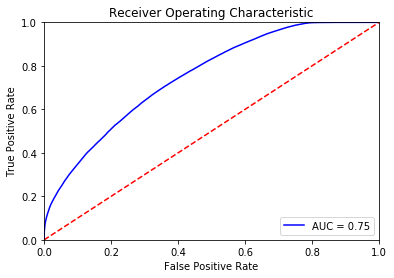

confusion matrix:
[[38606 21539]
 [17823 42322]]

classification report:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66     60145
           1       0.66      0.70      0.68     60145

    accuracy                           0.67    120290
   macro avg       0.67      0.67      0.67    120290
weighted avg       0.67      0.67      0.67    120290



In [10]:
import joblib
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

best = grid.best_estimator_

model = best
print('accuracy', model.score(X, y))

probs = model.predict_proba(X)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = model.predict(X)

cmatrix = confusion_matrix(y, y_pred)
print('confusion matrix:')
print(cmatrix)
print('\nclassification report:')
print(classification_report(y, y_pred))